In [1]:
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXVy7_7pF5FIsPp6WfXXfWgBNfUKx8N1VrTisN8FbGYG9w?download=1 -O Flickr8k_dataset.zip


--2023-03-28 08:43:26--  https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EXVy7_7pF5FIsPp6WfXXfWgBNfUKx8N1VrTisN8FbGYG9w?download=1
Resolving postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to postechackr-my.sharepoint.com (postechackr-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/dongbinna_postech_ac_kr/Documents/Research/datasets/Flickr8k_dataset.zip?ga=1 [following]
--2023-03-28 08:43:28--  https://postechackr-my.sharepoint.com/personal/dongbinna_postech_ac_kr/Documents/Research/datasets/Flickr8k_dataset.zip?ga=1
Reusing existing connection to postechackr-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 1112971163 (1.0G) [application/x-zip-compressed]
Saving to: ‘Flickr8k_dataset.zip’

Flickr8k_dataset.zi 100%[===================>]   1.04G  86.6MB/s    in 13s     

2023-03-28 0

In [2]:
%%capture
!unzip Flickr8k_dataset.zip -d ./Flickr8k_dataset

In [3]:
# !pip install torchtext==0.6.0

In [4]:
import os
from PIL import Image

image_dir = "./Flickr8k_dataset/Images" # 원본 이미지 파일 경로
train_image_dir = "./resized_train/images" # 크기가 조정된 이미지가 담길 경로 (학습)
val_image_dir = "./resized_val/images" # 크기가 조정된 이미지가 담길 경로 (평가)
test_image_dir = "./resized_test/images" # 크기가 조정된 이미지가 담길 경로 (테스트)
size = [256, 256] # 조정될 이미지 크기


def resize_image(image, size):
    # 이미지를 특정 크기로 조정
    return image.resize(size, Image.ANTIALIAS)

# image_dir 내부에 있는 모든 이미지의 크기를 바꾸어 결과 폴더로 옮기기
if not os.path.exists(train_image_dir):
    os.makedirs(train_image_dir)
if not os.path.exists(val_image_dir):
    os.makedirs(val_image_dir)
if not os.path.exists(test_image_dir):
    os.makedirs(test_image_dir)

images = sorted(os.listdir(image_dir)) # 이미지와 캡션 모두 파일 이름별로 정렬해서 매칭
num_images = len(images)
num_train_images = 6000 # 6000개는 학습용 데이터로 이용
num_val_images = 1000 # 1000개는 평가용 데이터로 이용

for i, image in enumerate(images):
    if (i + 1) <= num_train_images:
        output_dir = train_image_dir
    elif (i + 1) <= num_train_images + num_val_images:
        output_dir = val_image_dir
    else:
        output_dir = test_image_dir
    with open(os.path.join(image_dir, image), 'rb+') as f:
        with Image.open(f) as img:
            img = resize_image(img, size)
            img.save(os.path.join(output_dir, image), img.format)
    if (i + 1) % 500 == 0:
        print(f"[{i + 1}/{num_images}] Resized the images and saved into '{output_dir}'")
     

[500/8091] Resized the images and saved into './resized_train/images'
[1000/8091] Resized the images and saved into './resized_train/images'
[1500/8091] Resized the images and saved into './resized_train/images'
[2000/8091] Resized the images and saved into './resized_train/images'
[2500/8091] Resized the images and saved into './resized_train/images'
[3000/8091] Resized the images and saved into './resized_train/images'
[3500/8091] Resized the images and saved into './resized_train/images'
[4000/8091] Resized the images and saved into './resized_train/images'
[4500/8091] Resized the images and saved into './resized_train/images'
[5000/8091] Resized the images and saved into './resized_train/images'
[5500/8091] Resized the images and saved into './resized_train/images'
[6000/8091] Resized the images and saved into './resized_train/images'
[6500/8091] Resized the images and saved into './resized_val/images'
[7000/8091] Resized the images and saved into './resized_val/images'
[7500/8091]

In [5]:
import pickle
import nltk
from collections import Counter

nltk.download('punkt')

caption_path = "./Flickr8k_dataset/captions.txt" # 원본 캡션(caption) 파일
vocab_path = "./vocab.pkl" # 단어 사전 결과 파일
word_threshold = 4 # 최소 단어 등장 횟수
train_caption_path = "./resized_train/captions.txt" # 크기가 조정된 이미지의 캡션(caption)이 담길 경로 (학습)
val_caption_path = "./resized_val/captions.txt" # 크기가 조정된 이미지의 캡션(caption)이 담길 경로 (평가)
test_caption_path = "./resized_test/captions.txt" # 크기가 조정된 이미지의 캡션(caption)이 담길 경로 (테스트)


class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

counter = Counter()

with open(caption_path, "r") as f:
    lines = sorted(f.readlines()[1:])
    for i in range(len(lines)):
        line = lines[i]
        if (i + 1) <= num_train_images * 5: # 이미지당 캡션이 5개씩 존재
            output_caption = train_caption_path
        elif (i + 1) <= (num_train_images + num_val_images) * 5:
            output_caption = val_caption_path
        else:
            output_caption = test_caption_path
        index = line.find(",") # 캡션(caption) 문자열의 시작점 찾기
        caption = line[index + 1:] # 캡션(caption) 문자열 기록
        tokens = nltk.tokenize.word_tokenize(caption.lower()) # 문자열 토큰화
        counter.update(tokens) # 각 토큰의 개수 세기
        with open(output_caption, "a") as output_caption_f:
            output_caption_f.write(line)

# 단어의 빈도수가 특정 임계치(threshold) 이상인 경우에만 사용
words = [word for word, cnt in counter.items() if cnt >= word_threshold]

# Vocabulary 객체 생성
vocab = Vocabulary()
vocab.add_word('')
vocab.add_word('')
vocab.add_word('')
vocab.add_word('') # unknown 토큰

# Vocabulary 객체에 모든 단어를 담기
for word in words:
    vocab.add_word(word)

# Vocabulary 파일 저장
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
# 학습(train) 데이터셋의 캡션 수
!wc -l ./resized_train/captions.txt
# 평가(val) 데이터셋의 캡션 수
!wc -l ./resized_val/captions.txt
# 테스트(test) 데이터셋의 캡션 수
!wc -l ./resized_test/captions.txt

30000 ./resized_train/captions.txt
5000 ./resized_val/captions.txt
5455 ./resized_test/captions.txt


In [7]:
import torch.utils.data as data


# Flickr8k 데이터셋 클래스 정의
class Flickr8kDataset(data.Dataset):
    def __init__(self, root, captions, vocab, transform=None):
        self.root = root # 이미지가 존재하는 경로
        with open(captions, "r") as f:
             lines = f.readlines()
             self.captions = [] # 캡션(caption) 정보를 담을 리스트
             for line in lines: # 첫 번째 줄부터 바로 캡션 정보 존재
                index = line.find(",") # 캡션(caption) 문자열의 시작점 찾기
                path = line[:index] # 이미지 파일 이름
                caption = line[index + 1:] # 캡션(caption) 문자열 기록
                self.captions.append((path, caption))
        self.vocab = vocab
        self.transform = transform

    # 이미지와 캡션(caption)을 하나씩 꺼내는 메서드
    def __getitem__(self, index):
        vocab = self.vocab
        path = self.captions[index][0]
        caption = self.captions[index][1]

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # 캡션(caption) 문자열을 토큰 형태로 바꾸기
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab(''))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab(''))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.captions)

In [8]:
# 이미지와 캡션(caption)으로 구성된 튜플을 배치(batch)로 만들기
def collate_fn(data):
    """
    [입력]
    * data: list of tuple (image, caption). 
        * image: torch tensor of shape (3, 256, 256).
        * caption: torch tensor of shape (?); variable length.
    [출력]
    * images: torch tensor of shape (batch_size, 3, 256, 256).
    * targets: torch tensor of shape (batch_size, padded_length).
    * lengths: list; valid length for each padded caption.
    """
    # Caption 길이로 각 데이터를 내림차순 정렬
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # 리스트 형태의 이미지들을 텐서 하나로 합치기(데이터 개수, 3, 256, 256)
    images = torch.stack(images, 0)

    # 리스트 형태의 캡션들을 텐서 하나로 합치기(데이터 개수, 문장 내 최대 토큰 개수)
    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    # 하나씩 캡션을 확인하며 앞 부분의 내용을 패딩이 아닌 원래 토큰으로 채우기
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

def collate_fn_test(data):
    # 기존 순서를 그대로 사용 (차례대로 5개씩 같은 이미지를 표현)
    images, captions = zip(*data)

    # 리스트 형태의 이미지들을 텐서 하나로 합치기(데이터 개수, 3, 256, 256)
    images = torch.stack(images, 0)

    # 리스트 형태의 캡션들을 텐서 하나로 합치기(데이터 개수, 문장 내 최대 토큰 개수)
    lengths = [len(caption) for caption in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    # 하나씩 캡션을 확인하며 앞 부분의 내용을 패딩이 아닌 원래 토큰으로 채우기
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

# 커스텀 Flickr8k 데이터셋을 위한 DataLoader 객체 반환
def get_loader(root, captions, vocab, transform, batch_size, shuffle, num_workers, testing):
    flickr8k = Flickr8kDataset(root=root, captions=captions, vocab=vocab, transform=transform)
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    if not testing:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn)
    else:
        data_loader = torch.utils.data.DataLoader(dataset=flickr8k, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, collate_fn=collate_fn_test)
    return data_loader

In [9]:
!pip install einops


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 3.2 MB/s eta 0:00:00


In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn.functional as F
import numpy as np
from torchsummary import summary

# Einops
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

#vit
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_size=768, img_size=224):
        super().__init__()
        self.patch_size = patch_size

        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_size, patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')
        )

        self.cls_token = nn.Parameter(torch.randn(1,1,emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, emb_size))

    def forward(self, x):
        b = x.shape[0]
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)       
        x = torch.cat([cls_tokens, x], dim=1)   
        x += self.positions
        return x

class VitMultiHeadAttention(nn.Module):
    def __init__(self, emb_size = 768, num_heads = 8, dropout = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        
    def forward(self, x):
        # split keys, queries and values in num_heads
        # print(self.qkv(x).shape)
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        # print(qkv.shape)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # print(queries.shape,keys.shape)
        
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        # if mask is not None:
        #     fill_value = torch.finfo(torch.float32).min
        #     energy.masked_fill(mask==0, fill_value)

        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size, expansion = 4, drop_p = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

class TransformerEncoderBlock(nn.Sequential):
    def __init__(self, emb_size = 768, drop_p = 0., forward_expansion = 4, forward_drop_p = 0., ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                VitMultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            ))
        )

class TransformerEncoder(nn.Sequential):
    def __init__(self, depth = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

class VitHead(nn.Sequential):
    def __init__(self, emb_size = 768):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, emb_size),
            nn.BatchNorm1d(emb_size, momentum=0.01)
        )

class ViT(nn.Sequential):
    def __init__(self, in_channels = 3, patch_size = 16, emb_size = 768, img_size = 224, depth = 12, **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            VitHead(emb_size)
        )



In [11]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        # 하이퍼 파라미터(hyper-parameters) 설정 및 레이어 생성
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length

    def forward(self, features, captions, lengths):
        # 이미지 특징 벡터(feature vectors)로부터 캡션(caption) 생성
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1) # 이미지 특징과 임베딩 연결
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) # 패딩을 넣어 차원 맞추기
        hiddens, _ = self.lstm(packed) # 다음 hidden state 구하기
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, states=None):
        # 간단히 그리디(greedy) 탐색으로 캡션(caption) 생성하기
        sampled_indexes = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states) # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1)) # outputs: (batch_size, vocab_size)
            _, predicted = outputs.max(1) # predicted: (batch_size)
            sampled_indexes.append(predicted)
            inputs = self.embed(predicted) # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1) # inputs: (batch_size, 1, embed_size)
        sampled_indexes = torch.stack(sampled_indexes, 1) # sampled_indexes: (batch_size, max_seq_length)
        return sampled_indexes

In [12]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = "models/" # 학습된 모델이 저장될 경로
crop_size = 224 # 랜덤하게 잘라낼 이미지 크기
vocab_path = "./vocab.pkl" # 전처리된 Vocabulary 파일 경로

# 모델 디렉토리 만들기
if not os.path.exists(model_path):
    os.makedirs(model_path)

# Vocabulary 파일 불러오기
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# 사전 학습된(pre-trained) ResNet에 적용된 전처리 및 정규화 파라미터를 그대로 사용합니다.
train_transform = transforms.Compose([ 
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

val_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

test_transform = transforms.Compose([ 
    transforms.Resize(crop_size), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 128
num_workers = 2

# 데이터 로더(data loader) 선언
train_data_loader = get_loader(train_image_dir, train_caption_path, vocab, train_transform, batch_size, shuffle=True, num_workers=num_workers, testing=False) 
val_data_loader = get_loader(val_image_dir, val_caption_path, vocab, val_transform, batch_size, shuffle=False, num_workers=num_workers, testing=False)
test_data_loader = get_loader(test_image_dir, test_caption_path, vocab, test_transform, batch_size, shuffle=False, num_workers=num_workers, testing=True)


In [13]:
# 모델 하이퍼 파라미터 설정
embed_size = 768 # 임베딩(embedding) 차원
hidden_size = 1024 # LSTM hidden states 차원
num_layers = 1 # LSTM의 레이어 개수

# 모델 객체 선언
encoder =  ViT().to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

num_epochs = 30
learning_rate = 0.001

log_step = 20 # 로그를 출력할 스텝(step)
save_step = 1000 # 학습된 모델을 저장할 스텝(step)

# 손실(loss) 및 최적화 함수 선언
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.parameters()) 
optimizer = torch.optim.Adam(params, lr=learning_rate)

In [14]:
import time
import numpy as np

start_time = time.time() # 전체 학습 시간 측정

# 모델 학습 진행
for epoch in range(num_epochs):

    # 먼저 학습 진행하기
    print("[ Training ]")
    total_loss = 0
    total_count = 0
    total_step = len(train_data_loader)
    for i, (images, captions, lengths) in enumerate(train_data_loader):
        images = images.to(device)

        captions = captions.to(device)
        
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # 순전파(forward), 역전파(backward) 및 학습 진행
        features = encoder(images)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()
       
        # 손실(loss) 값 계산
        total_loss += loss.item()
        total_count += images.shape[0]

        # 로그(log) 정보 출력
        if i % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Average Loss: {:.4f}, Perplexity: {:5.4f}, Elapsed time: {:.4f}s'
                  .format(epoch, num_epochs, i, total_step, total_loss / total_count, np.exp(loss.item()), time.time() - start_time))
    print("[ Validation ]")
    total_loss = 0
    total_count = 0
    total_step = len(val_data_loader)
    with torch.no_grad():
        for i, (images, captions, lengths) in enumerate(val_data_loader):
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            # 순전파(forward) 진행
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
  
            # 손실(loss) 값 계산
            total_loss += loss.item()
            total_count += images.shape[0]

            # 로그(log) 정보 출력
            if i % log_step == 0:
                print('Epoch [{}/{}], Step [{}/{}], Average Loss: {:.4f}, Perplexity: {:5.4f}, Elapsed time: {:.4f}s'
                      .format(epoch, num_epochs, i, total_step, total_loss / total_count, np.exp(loss.item()), time.time() - start_time))

[ Training ]
Epoch [0/30], Step [0/235], Average Loss: 0.0637, Perplexity: 3478.7473, Elapsed time: 6.4853s
Epoch [0/30], Step [20/235], Average Loss: 0.0399, Perplexity: 63.3860, Elapsed time: 24.5175s
Epoch [0/30], Step [40/235], Average Loss: 0.0347, Perplexity: 29.1290, Elapsed time: 42.5274s
Epoch [0/30], Step [60/235], Average Loss: 0.0322, Perplexity: 30.2601, Elapsed time: 60.5297s
Epoch [0/30], Step [80/235], Average Loss: 0.0306, Perplexity: 26.6772, Elapsed time: 78.5339s
Epoch [0/30], Step [100/235], Average Loss: 0.0295, Perplexity: 22.9558, Elapsed time: 96.5295s
Epoch [0/30], Step [120/235], Average Loss: 0.0286, Perplexity: 23.9298, Elapsed time: 114.5267s
Epoch [0/30], Step [140/235], Average Loss: 0.0280, Perplexity: 21.7547, Elapsed time: 132.5220s
Epoch [0/30], Step [160/235], Average Loss: 0.0274, Perplexity: 18.6660, Elapsed time: 150.5255s
Epoch [0/30], Step [180/235], Average Loss: 0.0269, Perplexity: 21.4049, Elapsed time: 168.5340s
Epoch [0/30], Step [200/235]

In [23]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

# image_path = "/content/resized_train/images/1000268201_693b08cb0e.jpg" # 캡션(caption)을 생성할 입력 이미지
image_path = '/content/resized_test/images/3717845800_ab45e255b8.jpg'
vocab_path = "./vocab.pkl" # path for vocabulary wrapper

# encoder.eval()
# decoder.eval()
     

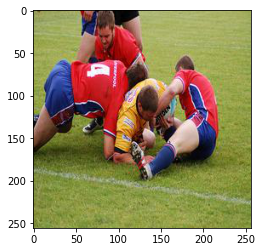

 a soccer player in a white shirt kicked a goal .  a man in a red sweatshirt is


In [24]:
# 이미지 전처리(image preprocessing)
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)


# Prepare an image
image = load_image(image_path, transform)
image_tensor = image.to(device)

# Generate an caption from the image
feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy() # (1, max_seq_length) -> (max_seq_length)

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids: # 하나씩 단어 인덱스를 확인하며
    word = vocab.idx2word[word_id] # 단어 문자열로 바꾸어 삽입
    sampled_caption.append(word)
    # if word == '':
    #     break
sentence = ' '.join(sampled_caption)
     

import matplotlib.pyplot as plt

# 이미지 및 생성된 캡션(caption) 문장 출력
image = Image.open(image_path)
plt.imshow(np.asarray(image))
plt.show()
print(sentence)


In [21]:
sampled_ids

array([  0,   1,  73,   3,   1, 105, 155,   6, 946, 535,  23,   1,  63,
        27,  14,   0,   1,  27,  14,   0])